In [1]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import numpy as np
import pandas as pd
import os
import pickle
import sys
import math
import copy

import utils.plot_functions as pf
import utils.data_processing as dp
import utils.rate_distortion as rd

import scipy.stats
import scipy.cluster.vq as vq
from sklearn import cluster
from sklearn.utils.testing import SkipTest
from skimage.measure import compare_ssim as ssim
from sklearn.utils.fixes import sp_version

In [2]:
with np.load("/media/tbell/sanborn/rd_analysis/outputs/pca/coeffs/pca_coeffs.npz") as d:
    pca_coeffs = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/outputs/pca/coeffs/pca_weights.npz") as d:
    pca_weights = d['arr_0']

In [9]:
with np.load("/media/tbell/sanborn/rd_analysis/inputs/vh_test_lpf2.npz") as d:
    lpf = d['arr_0'].item()

In [19]:
with np.load("/media/tbell/sanborn/rd_analysis/outputs/ica/coeffs/ica_v1.0_coeffs.npz") as d:
    ica_coeffs = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/outputs/ica/coeffs/ica_v1.0_coeffs_squashed.npz") as d:
    ica_coeffs_squashed = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/outputs/ica/coeffs/ica_v1.0_weights.npz") as d:
    ica_weights = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/outputs/ica/coeffs/ica_v1.0_weights_inv.npz") as d:
    ica_weights_inv = d['arr_0']

In [20]:
with np.load("/media/tbell/sanborn/rd_analysis/outputs/lca_ft_posneg/coeffs/lca_256_l0_2.5_v1.0_coeffs.npz") as d:
    lca_coeffs = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/outputs/lca_ft_posneg/coeffs/lca_256_l0_2.5_v1.0_weights.npz") as d:
    lca_weights = d['arr_0']
with np.load("/media/tbell/sanborn/rd_analysis/inputs/vh_test_ftwhite2.npz") as d:
    ftwhite = d['arr_0'].item()

In [66]:
def discretize_coeffs(coeffs, bins, params, bf_length_factors=None, plot=False, crop_idxs=None, img_idx="unspecified"):
    coeffs = dp.reshape_data(coeffs, flatten=True)[0]
    discretized_coeffs = np.zeros(coeffs.shape)
    entropy = []
    nbins = []
    hists = []
    edges = []
    centers = []
    distributions = []
    for idx, row in enumerate(coeffs.T): 
        if bf_length_factors is not None:
            bin_width = bins * bf_length_factors[idx]
        else:
            bin_width = bins
        if params["set_fixed_range"]:
            num_neg_bins = math.ceil(abs(params["range_min"]) / bin_width)
            num_pos_bins = math.ceil(abs(params["range_max"]) / bin_width)
            positive_bins = [bin_width/2]
            negative_bins = [-bin_width/2]
            for n in range(num_neg_bins):
                negative_bins.append(negative_bins[-1]-bin_width)
            for n in range(num_pos_bins):
                positive_bins.append(positive_bins[-1]+bin_width)
            bin_edges = np.array(negative_bins[::-1] + positive_bins)
            nbins.append(len(bin_edges)-1)
            bin_edges[-1] += 1e-6
        else:
            coeff_range = np.max(row) - np.min(row)
            nbins = math.ceil(coeff_range / bin_width)
            if nbins == 0:
                bin_edges = np.linspace(-bin_width/2, bin_width/2, 2, dtype=np.float64)
            else:
                bin_edges = np.linspace(np.min(row), np.max(row), nbins+1, dtype=np.float64)
                bin_edges[-1] += 1e-6
        bin_centers = bin_edges[1:] - bin_width/2
        if params['disc_type'] == 'uniform':
            bin_centers = np.append(bin_centers, bin_centers[-1] + bin_width)
            bin_centers = np.insert(bin_centers, [0], bin_centers[0] - bin_width)
            bin_idxs = np.digitize(row, bin_edges)
            disc = [bin_centers[i] for i in bin_idxs]
            discretized_coeffs[:, idx] = disc
            if crop_idxs is not None:
                hist_batch = [x for i, x in enumerate(row) if i not in crop_idxs]
            else: 
                hist_batch = row
            hist = np.histogram(hist_batch, bin_edges, range=(params["range_min"], params["range_max"]))[0]
        elif params['disc_type'] == 'lloyd_max':
            disc, bin_edges, bin_centers = lloyd_max(row, bin_edges, bin_centers, epsilon=1e-4, EC=True, lam=.5)
#             disc, bin_edges, bin_centers = lloyd_max(row, bin_edges, bin_centers)
            discretized_coeffs[:, idx] = disc
            hist, bin_edges = np.histogram(row, bin_edges)
            edges.append(bin_edges)
            centers.append(bin_centers)
        else:
            raise ValueError("Undefined disc_type")  
        distribution = hist/np.sum(hist)
        entropy.append(scipy.stats.entropy(distribution))        
    if plot:
        plot_coeff_hists(hists, edges, params, img_idx, bins)
    H = np.mean(entropy)
    nbins = np.mean(nbins)
    return discretized_coeffs, H, nbins, edges, centers

def lloyd_max_v1(coeffs, bin_edges, bin_centers, max_iter=1000):
    for i in range(max_iter+1):
        init_bin_edges = copy.deepcopy(bin_edges)
        for j, c in enumerate(bin_centers):
            vals = np.array([c for c in coeffs if c >= bin_edges[j] and c < bin_edges[j+1]])
            if len(vals) == 0:
                bin_centers[j] = (bin_edges[j] + bin_edges[j+1]) / 2
            else:
                bin_centers[j] = np.mean(vals)
        for j, e in enumerate(bin_edges):
            if e != bin_edges[0] and e != bin_edges[-1]:
                bin_edges[j] = (bin_centers[j] + bin_centers[j-1]) / 2
        if np.mean((bin_edges -  init_bin_edges)**2) < 1e-6:
            break
    if i == max_iter:
        print("max iter reached")
    bin_centers = np.insert(bin_centers, 0, bin_edges[0])
    bin_centers = np.append(bin_centers, bin_edges[-1])
    bin_idxs = np.digitize(coeffs, bin_edges)
    discretized_coeffs = np.array([bin_centers[i] for i in bin_idxs])
    return discretized_coeffs, bin_edges, bin_centers

def quantize(raw_scalar_vals, edges, assignments):
    return assignments[np.digitize(raw_scalar_vals, edges, right=True) - 1]
    #^ using convention that intervals are open on the LHS and closed on the RHS

def lloyd_max(coeffs, init_bin_edges, init_assignments_pts, epsilon=1e-4, EC=False, lam=.5):
    assert np.all(np.diff(init_assignments_pts) > 0)  # monotonically increasing
    assignment_pts = np.copy(init_assignments_pts)
    bin_edges = np.hstack([-np.inf, init_bin_edges, np.inf])
    cost = 0.0
    old_cost = np.inf
    while np.abs(old_cost - cost) > epsilon:
        #^ this algorithm provably reduces MSE or leaves it unchanged at each
        #  iteration so the boundedness of MSE means this is a valid stopping
        #  criterion
        old_cost = np.copy(cost)  
#         bin_edges = (assignment_pts[:-1] + assignment_pts[1:]) / 2
        
    
        bin_edges = np.hstack(
            [-np.inf, (assignment_pts[:-1] + assignment_pts[1:]) / 2, np.inf])
        if EC:
            hist, bin_edges = np.histogram(coeffs, bin_edges)
            dist = hist / np.sum(hist)
            
            ec_terms = np.hstack([-np.inf, (lam *( np.log2(dist[:-1]) - np.log2(dist[1:]))) / (2 * (assignment_pts[:-1] - assignment_pts[1:]) ), np.inf])
            ec_terms[np.isnan(ec_terms)] = 0
            ec_terms[ec_terms == -np.inf] = 0
            ec_terms[ec_terms == np.inf] = 0
            #             bin_edges = np.hstack([-np.inf, (bin_edges[1:-1] - ), np.inf])
            bin_edges = np.array(bin_edges) - np.array(ec_terms)
        binned_vals = [[] for _ in range(len(init_assignments_pts))]
        for coeff in coeffs:
            bin_assignment = int(np.digitize(coeff, bin_edges, right=True) - 1)
            binned_vals[bin_assignment].append(coeff)
        for bin_idx in range(len(binned_vals)):
            if len(binned_vals[bin_idx]) != 0:   # can happen for low sample count
                assignment_pts[bin_idx] = np.mean(binned_vals[bin_idx])
              # otherwise don't update the assignment point
            quantized_coeffs = quantize(coeffs, bin_edges, assignment_pts)
            cost = np.mean(np.square(quantized_coeffs - coeffs))
            if EC:
                hist, bin_edges = np.histogram(coeffs, bin_edges)
                dist = hist / np.sum(hist)
                H = scipy.stats.entropy(dist)
                cost += lam * H    
    return quantize(coeffs, bin_edges, assignment_pts), bin_edges, assignment_pts

In [ ]:
def lloyd_max(coeffs, init_assignments_pts, init_bin_edges, epsilon=1e-4, EC=False, lam=.5):
    assert np.all(np.diff(init_assignments_pts) > 0)  # monotonically increasing
    assignment_pts = np.copy(init_assignments_pts)
    bin_edges = np.hstack([-np.ing, init_bin_edges, np.inf])
    print(bin_edges)
    cost = 0.0
    old_cost = np.inf
    while np.abs(old_cost - cost) > epsilon:
        #^ this algorithm provably reduces MSE or leaves it unchanged at each
        #  iteration so the boundedness of MSE means this is a valid stopping
        #  criterion
        old_cost = np.copy(cost)  
#         bin_edges = (assignment_pts[:-1] + assignment_pts[1:]) / 2
#         print(np.min(coeffs))
#         print(bin_edges)
#         bin_edges = np.hstack(
#             [-np.inf, (assignment_pts[:-1] + assignment_pts[1:]) / 2, np.inf])
        if EC:
            hist, bin_edges = np.histogram(coeffs, bin_edges)
            dist = hist / np.sum(hist)
            print(bin_edges)
            print(dist.shape)
            print(assignment_pts.shape)
            ec_terms = np.hstack([0, (lam *( np.log2(dist[:-1]) - np.log2(dist[1:]))) / (2 * (assignment_pts[:-1] - assignment_pts[1:])), 0])
#             print(ec_terms.shape)
            ec_terms[np.isnan(ec_terms)] = 0
            ec_terms[ec_terms == -np.inf] = 0
            ec_terms[ec_terms == np.inf] = 0
        
            #             bin_edges = np.hstack([-np.inf, (bin_edges[1:-1] - ), np.inf])
            bin_edges = np.array(bin_edges) - np.array(ec_terms)
            print(bin_edges)
        binned_vals = [[] for _ in range(len(init_assignments_pts))]
        for coeff in coeffs:
            bin_assignment = int(np.digitize(coeff, bin_edges, right=True) - 1)
            binned_vals[bin_assignment].append(coeff)
        for bin_idx in range(len(binned_vals)):
            if len(binned_vals[bin_idx]) != 0:   # can happen for low sample count
                assignment_pts[bin_idx] = np.mean(binned_vals[bin_idx])
              # otherwise don't update the assignment point
            quantized_coeffs = quantize(coeffs, bin_edges, assignment_pts)
            cost = np.mean(np.square(quantized_coeffs - coeffs))
            if EC:
                hist, bin_edges = np.histogram(coeffs, bin_edges)
                dist = hist / np.sum(hist)
                H = scipy.stats.entropy(dist)
                cost += lam * H    
    return quantize(coeffs, bin_edges, assignment_pts), bin_edges, assignment_pts

In [4]:
def plot_quantization(coeffs, coeff_idx, edges, centers):
    plt.rcParams["figure.figsize"] = [25,10]
    fig, ax = plt.subplots()
    plt.hist(coeffs[:,coeff_idx], edges[coeff_idx]);
    plt.xticks(sorted(list(edges[coeff_idx]) + list(centers[coeff_idx])));
    hist, bin_edges = np.histogram(coeffs[:,coeff_idx], edges[coeff_idx])
    distribution = hist / np.sum(hist)
    plt.title("entropy: " + str(round(scipy.stats.entropy(distribution), 2)), size=20)
    for c in centers[coeff_idx]:
        plt.axvline(x=c, color='k', linestyle='--')
    for e in edges[coeff_idx]:
        plt.axvline(x=e, color='k', linestyle='-')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

In [5]:
def plot_recon(recon, psnr_db, mse, struc_sim, H):
    plt.rcParams["figure.figsize"] = [15,15]
    plt.imshow(recon.squeeze(), cmap="Greys_r");
    plt.title('psnr: ' + str(round(np.mean(psnr_db), 2)) + '    mse: ' + str(round(mse, 6)) + "   ssim: " + str(round(struc_sim, 2)) + "    H: " + str(round(H, 2)), size=20)

In [6]:
def discretize_and_recon(coeffs, weights, dataset, params, img_idx=0, bf_length_factors=None):  
    data = dataset['train'].images
    data_mean = dataset['train'].data_mean
    if params["white"]:
        unwhite_weights, lengths, bf_length_factors, invw_filter = rd.unwhiten_bases(weights)
    img_coeffs = coeffs[img_idx * 4096:(img_idx+1) * 4096]
    discretized_coeffs, H, nbins, edges, centers = discretize_coeffs(img_coeffs, params["bin_width"], params, bf_length_factors, img_idx=img_idx)
    if params["white"] == True:
        data = dp.unwhiten_data(data, data_mean, method=params["whiten_method"])
    else:
        data = dp.reshape_data(data, flatten=False)[0]
        data = dp.patches_to_image(data, [params["num_images"], params['im_edge_size'], params['im_edge_size'], 1])
        data += data_mean
    if "crop_border" in params and params["crop_border"]:
        data, crop_idxs = rd.crop_border(data, params)
    data_range = np.max(data, axis=(1,2)) - np.min(data, axis=(1,2))
    if params["model"] == "pca":
        reconstructions = np.matmul(discretized_coeffs, np.linalg.inv(weights))
    else:
        reconstructions = np.matmul(discretized_coeffs, weights.T)
    reconstructions = dp.reshape_data(reconstructions, flatten=False)[0]
    if params["white"] == True:
        reconstructions = dp.unwhiten_data(reconstructions, data_mean[img_idx], method=params["whiten_method"])  
    else: 
        reconstructions = dp.patches_to_image(reconstructions, [1, params['im_edge_size'], params['im_edge_size'], 1])
        reconstructions += data_mean[img_idx]
    if "crop_border" in params and params["crop_border"]:
        reconstructions, crop_idxs = rd.crop_border(reconstructions, params)
    mse = np.mean((data[img_idx] - reconstructions) ** 2)
    mse_sd = np.std(mse)
    psnr = data_range[img_idx] ** 2 / mse
    psnr_db = 10 * np.log10(psnr)
    struc_sim = ssim(data[img_idx].squeeze(), reconstructions.squeeze(), data_range=data_range[img_idx])
    return reconstructions, img_coeffs, discretized_coeffs, edges, centers, mse, psnr_db, struc_sim, H
    

In [68]:
params = {
    "disc_type": "lloyd_max",
    "set_fixed_range": False,
    "range_min": -60,
    "range_max": 60,
    "model": "lca",
    "white": True,
    "whiten_method": "FT",
    "im_edge_size": 1024,
    "patch_edge_size": 16,
    "n_pixels": 256,
    "num_images": 25,
    "crop_border": True,
    "bin_width": 5,
    "EC": True,
    "lam": 1e-6
}
img_idx=1

In [69]:
reconstructions, img_coeffs, discretized_coeffs, edges, centers, mse, psnr, struc_sim, H = discretize_and_recon(lca_coeffs, lca_weights, ftwhite, params,img_idx)

/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:109: RuntimeWarning: divide by zero encountered in log2
/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in subtract


ValueError: bins must be monotonically increasing or decreasing

In [42]:
coeff_idx=4

plot_quantization(img_coeffs, coeff_idx, edges, centers)

/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:6260: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)
/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/matplotlib/transforms.py:2714: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx = np.array([[x_scale, 0.0    , (-inl*x_scale)],


LinAlgError: Singular matrix

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa71b879d90> (for post_execute):


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

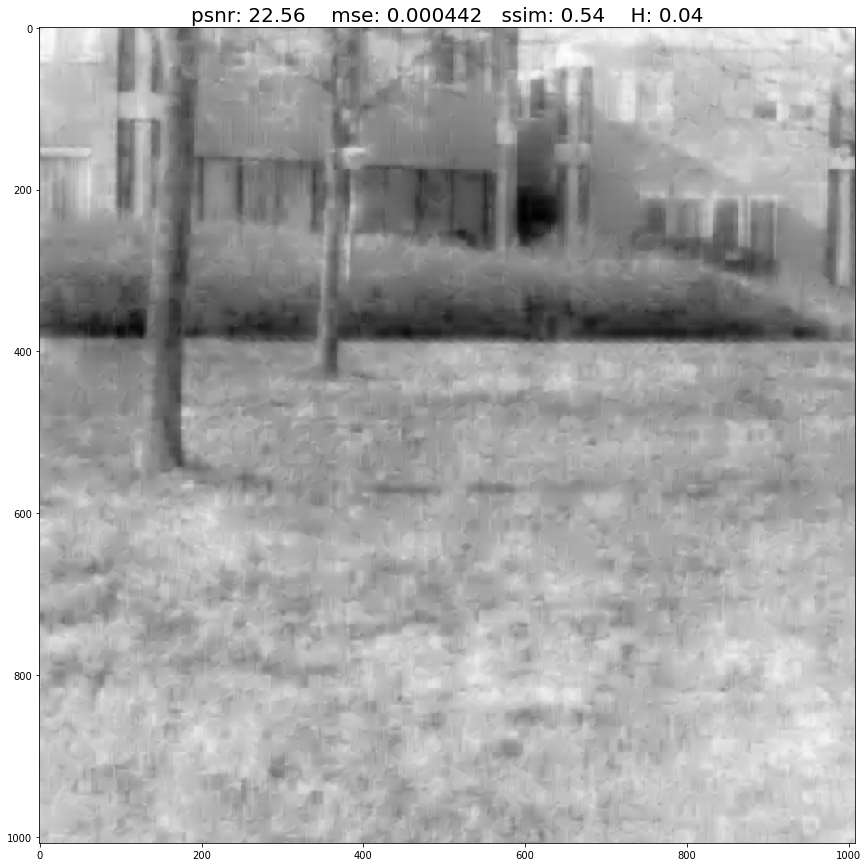

In [55]:
plt.rcParams["figure.figsize"] = [15,15]
plt.imshow(reconstructions.squeeze(), cmap="Greys_r");
plt.title('psnr: ' + str(round(np.mean(psnr), 2)) + '    mse: ' + str(round(mse, 6)) + "   ssim: " + str(round(struc_sim, 2)) + "    H: " + str(round(H, 2)), size=20);

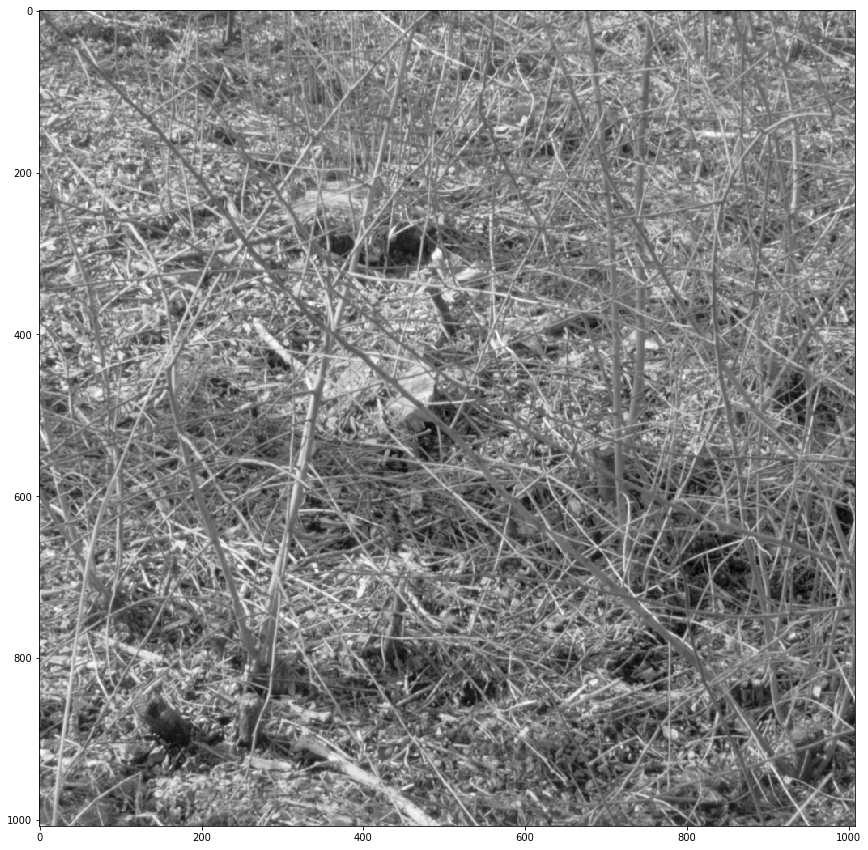

In [42]:
plt.rcParams["figure.figsize"] = [15,15]
plt.imshow(data[img_idx].squeeze(), cmap="Greys_r");

In [24]:
params = {
    "disc_type": "lloyd_max",
    "set_fixed_range": False,
    "range_min": -3,
    "range_max": 3,
    "model": "pca",
    "white": False,
    "whiten_method": "FT",
    "im_edge_size": 1024,
    "patch_edge_size": 16,
    "n_pixels": 256,
    "num_images": 25,
    "crop_border": True,
    "bin_width": .1,
    "EC": True,
    "lam": 1e-5
}
img_idx=0

In [12]:
pca_reconstructions, pca_img_coeffs, pca_discretized_coeffs, pca_edges, pca_centers, pca_mse, pca_psnr, pca_struc_sim, pca_H = discretize_and_recon(pca_coeffs, pca_weights, lpf, params, img_idx)

[-1.24632817 -1.14895913 -1.0515901  -0.95422107 -0.85685203 -0.759483
 -0.66211397 -0.56474493 -0.4673759  -0.37000687 -0.27263784 -0.1752688
 -0.07789977  0.01946926  0.1168383   0.21420733  0.31157636  0.4089454
  0.50631443  0.60368346  0.70105249  0.79842153  0.89579056  0.99315959
  1.09052863  1.18789866]
[-1.19895913 -1.1015901  -1.00422107 -0.90685203 -0.809483   -0.71211397
 -0.61474493 -0.5173759  -0.42000687 -0.32263784 -0.2252688  -0.12789977
 -0.03053074  0.0668383   0.16420733  0.26157636  0.3589454   0.45631443
  0.55368346  0.65105249  0.74842153  0.84579056  0.94315959  1.04052863
  1.13789866]
[-1.24632817 -1.14895913 -1.0515901  -0.95419103 -0.85698162 -0.75947265
 -0.66219025 -0.5647929  -0.46742725 -0.37003527 -0.27267111 -0.1752697
 -0.07790713  0.01948234  0.11685107  0.2142315   0.31158417  0.4089814
  0.50633916  0.6037135   0.70108772  0.79846973  0.89584836  0.99319308
  1.09062144  1.18789866]
[-1.24632817 -1.14895913 -1.0515901  -0.9541524  -0.85709546 -0.

/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2



[-0.45419658 -0.35997496 -0.2654806  -0.17095004 -0.07637086  0.01827437
  0.11291741  0.20747007  0.30206542  0.39620494]
[-0.42809398 -0.33070944 -0.23332489 -0.13594035 -0.0385558   0.05882874
  0.15621329  0.25359784  0.35098238  0.44836793]
[-0.38070944 -0.28332489 -0.18594035 -0.0885558   0.00882874  0.10621329
  0.20359784  0.30098238  0.39836793]
[-0.42809398 -0.33081212 -0.23342201 -0.13603565 -0.03858586  0.05886956
  0.15630917  0.25374321  0.35109945  0.44836793]
[-0.42809398 -0.33091601 -0.23351917 -0.13613144 -0.03861884  0.05891506
  0.15640822  0.25390225  0.35177262  0.44836793]
[-0.52646604 -0.43409094 -0.34171585 -0.24934075 -0.15696565 -0.06459055
  0.02778455  0.12015964  0.21253474  0.30490984  0.39728594]
[-0.48409094 -0.39171585 -0.29934075 -0.20696565 -0.11459055 -0.02221545
  0.07015964  0.16253474  0.25490984  0.34728594]
[-0.52646604 -0.43421662 -0.34181801 -0.24946298 -0.15707412 -0.06464979
  0.02780157  0.12025844  0.21265907  0.30505435  0.39728594]
[-0

[-0.14969327 -0.05828503  0.03476133  0.12638814]
[-0.14477539 -0.05538936  0.03399667  0.1233837 ]
[-0.10538936 -0.01600333  0.0733837 ]
[-0.14477539 -0.05564632  0.03416223  0.1233837 ]
[-0.14477539 -0.05597833  0.03443345  0.1233837 ]
[-0.1150343  -0.03404661  0.04694107  0.12792976]
[-0.08404661 -0.00305893  0.07792976]
[-0.1150343  -0.03424604  0.04721114  0.12792976]
[-0.1150343  -0.03457565  0.0475895   0.12792976]
[-0.11319217 -0.03116919  0.0508538   0.13287778]
[-0.08116919  0.0008538   0.08287778]
[-0.11319217 -0.03133898  0.05113509  0.13287778]
[-0.11319217 -0.03161371  0.05152179  0.13287778]
[-0.12543486 -0.05162213  0.02219059  0.09600432]
[-0.10162213 -0.02780941  0.04600432]
[-0.12543486 -0.05194097  0.02232712  0.09600432]
[-0.12543486 -0.05234993  0.02255788  0.09600432]
[-0.1285459  -0.04615613  0.03623364  0.11862441]
[-0.09615613 -0.01376636  0.06862441]
[-0.1285459  -0.0464251   0.03644458  0.11862441]
[-0.1285459  -0.04679949  0.03677295  0.11862441]
[-0.109716

[-0.02406293  0.02725929]
[-0.02274071]
[-0.02406293  0.02725929]
[-0.02299836  0.02123654]
[-0.02876346]
[-0.02299836  0.02123654]
[-0.02185456  0.01730086]
[-0.03269914]
[-0.02185456  0.01730086]
[-0.02023944  0.02002731]
[-0.02997269]
[-0.02023944  0.02002731]
[-0.01689562  0.02240506]
[-0.02759494]
[-0.01689562  0.02240506]
[-0.02522521  0.01823132]
[-0.03176868]
[-0.02522521  0.01823132]
[-0.01480961  0.01908292]
[-0.03091708]
[-0.01480961  0.01908292]
[-0.02012363  0.01939786]
[-0.03060214]
[-0.02012363  0.01939786]
[-0.01879629  0.01710822]
[-0.03289178]
[-0.01879629  0.01710822]
[-0.02062094  0.01836979]
[-0.03163021]
[-0.02062094  0.01836979]
[-0.01508505  0.01563539]
[-0.03436461]
[-0.01508505  0.01563539]
[-0.01784034  0.01657527]
[-0.03342473]
[-0.01784034  0.01657527]
[-0.01604777  0.01654386]
[-0.03345614]
[-0.01604777  0.01654386]
[-0.01629204  0.01718959]
[-0.03281041]
[-0.01629204  0.01718959]
[-0.01698034  0.01766836]
[-0.03233164]
[-0.01698034  0.01766836]
[-0.016605

[-0.00223071  0.0020639 ]
[-0.0479361]
[-0.00223071  0.0020639 ]
[-0.0024995  0.0020747]
[-0.0479253]
[-0.0024995  0.0020747]
[-0.00185323  0.00209746]
[-0.04790254]
[-0.00185323  0.00209746]
[-0.00226332  0.0021791 ]
[-0.0478209]
[-0.00226332  0.0021791 ]
[-0.00160972  0.0022539 ]
[-0.0477461]
[-0.00160972  0.0022539 ]
[-0.00154244  0.00229646]
[-0.04770354]
[-0.00154244  0.00229646]
[-0.00197592  0.00182715]
[-0.04817285]
[-0.00197592  0.00182715]
[-0.0016471   0.00165232]
[-0.04834768]
[-0.0016471   0.00165232]
[-0.00189301  0.00145949]
[-0.04854051]
[-0.00189301  0.00145949]
[-0.0013499   0.00139844]
[-0.04860156]
[-0.0013499   0.00139844]
[-0.00158507  0.0013142 ]
[-0.0486858]
[-0.00158507  0.0013142 ]
[-0.00107865  0.00166077]
[-0.04833923]
[-0.00107865  0.00166077]


In [27]:
pca_reconstructions, pca_img_coeffs, pca_discretized_coeffs, pca_edges, pca_centers, pca_mse, pca_psnr, pca_struc_sim, pca_H = discretize_and_recon(pca_coeffs, pca_weights, lpf, params, img_idx)

[-64.       -56.       -48.       -40.       -32.       -24.       -16.
  -8.         0.         8.        16.        24.        32.        40.
  48.        56.        64.000001]
[-68.       -60.       -52.       -44.       -36.       -28.       -20.
 -12.        -4.         4.        12.        20.        28.        36.
  44.        52.        60.        68.000001]
[-68.       -60.       -52.       -44.       -36.       -28.       -20.
 -12.        -4.         4.        12.        20.        28.        36.
  44.        52.        60.        68.000001]
[-66.56239163 -55.46865969 -44.37492775 -33.28119581 -22.18746388
 -11.09373194   0.          11.09373194  22.18746388  33.28119581
  44.37492775  55.46865969  66.56239263]
[-72.1092576  -61.01552566 -49.92179372 -38.82806178 -27.73432985
 -16.64059791  -5.54686597   5.54686597  16.64059791  27.73432985
  38.82806178  49.92179372  61.01552566  72.1092586 ]
[-72.1092576  -61.01552566 -49.92179372 -38.82806178 -27.73432985
 -16.64059791  -

/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: divide by zero encountered in log2
/home/sanborn/virtual_envs/py3/lib/python3.4/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in subtract


[-66.37284516 -53.09827613 -39.8237071  -26.54913806 -13.27456903   0.
  13.27456903  26.54913806  39.8237071   53.09827613  66.37284616]
[-73.01012968 -59.73556064 -46.46099161 -33.18642258 -19.91185355
  -6.63728452   6.63728452  19.91185355  33.18642258  46.46099161
  59.73556064  73.01013068]
[-73.01012968 -59.73556064 -46.46099161 -33.18642258 -19.91185355
  -6.63728452   6.63728452  19.91185355  33.18642258  46.46099161
  59.73556064  73.01013068]
[-70.37375473 -56.29900378 -42.22425284 -28.14950189 -14.07475095   0.
  14.07475095  28.14950189  42.22425284  56.29900378  70.37375573]
[-77.4111302  -63.33637925 -49.26162831 -35.18687736 -21.11212642
  -7.03737547   7.03737547  21.11212642  35.18687736  49.26162831
  63.33637925  77.4111312 ]
[-77.4111302  -63.33637925 -49.26162831 -35.18687736 -21.11212642
  -7.03737547   7.03737547  21.11212642  35.18687736  49.26162831
  63.33637925  77.4111312 ]
[-63.8046876 -47.8535157 -31.9023438 -15.9511719   0.         15.9511719
  31.902343

[-92.50472469 -66.07480335 -39.64488201 -13.21496067  13.21496067
  39.64488201  66.07480335  92.50472569]
[-81.30547854 -54.20365236 -27.10182618   0.          27.10182618
  54.20365236  81.30547954]
[-94.85639163 -67.75456545 -40.65273927 -13.55091309  13.55091309
  40.65273927  67.75456545  94.85639263]
[-94.85639163 -67.75456545 -40.65273927 -13.55091309  13.55091309
  40.65273927  67.75456545  94.85639263]
[-84.24298629 -56.16199086 -28.08099543   0.          28.08099543
  56.16199086  84.24298729]
[-98.283484   -70.20248857 -42.12149314 -14.04049771  14.04049771
  42.12149314  70.20248857  98.283485  ]
[-98.283484   -70.20248857 -42.12149314 -14.04049771  14.04049771
  42.12149314  70.20248857  98.283485  ]
[-84.35377741 -56.23585161 -28.1179258    0.          28.1179258
  56.23585161  84.35377841]
[-98.41274031 -70.29481451 -42.17688871 -14.0589629   14.0589629
  42.17688871  70.29481451  98.41274131]
[-98.41274031 -70.29481451 -42.17688871 -14.0589629   14.0589629
  42.17688871

[-74.54093702 -37.27046851   0.          37.27046851  74.54093802]
[-93.17617127 -55.90570276 -18.63523425  18.63523425  55.90570276
  93.17617227]
[-93.17617127 -55.90570276 -18.63523425  18.63523425  55.90570276
  93.17617227]
[-74.05655092 -37.02827546   0.          37.02827546  74.05655192]
[-92.57068866 -55.54241319 -18.51413773  18.51413773  55.54241319
  92.57068966]
[-92.57068866 -55.54241319 -18.51413773  18.51413773  55.54241319
  92.57068966]
[-74.01431406 -37.00715703   0.          37.00715703  74.01431506]
[-92.51789258 -55.51073555 -18.50357852  18.50357852  55.51073555
  92.51789358]
[-92.51789258 -55.51073555 -18.50357852  18.50357852  55.51073555
  92.51789358]
[-75.48564295 -37.74282147   0.          37.74282147  75.48564395]
[-94.35705369 -56.61423221 -18.87141074  18.87141074  56.61423221
  94.35705469]
[-94.35705369 -56.61423221 -18.87141074  18.87141074  56.61423221
  94.35705469]
[-75.77419863 -37.88709932   0.          37.88709932  75.77419963]
[-94.71774829 -56

[-94.22166415 -47.11083208   0.          47.11083208  94.22166515]
[-117.77708019  -70.66624811  -23.55541604   23.55541604   70.66624811
  117.77708119]
[-94.33956542 -47.16978271   0.          47.16978271  94.33956642]
[-117.92445678  -70.75467407  -23.58489136   23.58489136   70.75467407
  117.92445778]
[-95.64858252 -47.82429126   0.          47.82429126  95.64858352]
[-119.56072814  -71.73643689  -23.91214563   23.91214563   71.73643689
  119.56072914]
[-96.54748937 -48.27374469   0.          48.27374469  96.54749037]
[-120.68436171  -72.41061703  -24.13687234   24.13687234   72.41061703
  120.68436271]
[-95.71415177 -47.85707589   0.          47.85707589  95.71415277]
[-119.64268971  -71.78561383  -23.92853794   23.92853794   71.78561383
  119.64269071]
[-95.65802606 -47.82901303   0.          47.82901303  95.65802706]
[-119.57253257  -71.74351954  -23.91450651   23.91450651   71.74351954
  119.57253357]
[-95.61388019 -47.8069401    0.          47.8069401   95.61388119]
[-119.517

[-112.39593912  -56.19796956    0.           56.19796956  112.39594012]
[-140.4949239   -84.29695434  -28.09898478   28.09898478   84.29695434
  140.4949249 ]
[-113.24611796  -56.62305898    0.           56.62305898  113.24611896]
[-141.55764745  -84.93458847  -28.31152949   28.31152949   84.93458847
  141.55764845]
[-115.23766572  -57.61883286    0.           57.61883286  115.23766672]
[-144.04708216  -86.42824929  -28.80941643   28.80941643   86.42824929
  144.04708316]
[-113.30941366  -56.65470683    0.           56.65470683  113.30941466]
[-141.63676707  -84.98206024  -28.32735341   28.32735341   84.98206024
  141.63676807]
[-112.3597622  -56.1798811    0.          56.1798811  112.3597632]
[-140.44970275  -84.26982165  -28.08994055   28.08994055   84.26982165
  140.44970375]
[-116.70434116  -58.35217058    0.           58.35217058  116.70434216]
[-145.88042645  -87.52825587  -29.17608529   29.17608529   87.52825587
  145.88042745]
[-113.38862534  -56.69431267    0.           56.694

[-71.25160198   0.          71.25160298]
[-106.87740298  -35.62580099   35.62580099  106.87740398]
[-72.85088459   0.          72.85088559]
[-109.27632689  -36.4254423    36.4254423   109.27632789]
[-73.01131347   0.          73.01131447]
[-109.5169702   -36.50565673   36.50565673  109.5169712 ]
[-73.08931744   0.          73.08931844]
[-109.63397616  -36.54465872   36.54465872  109.63397716]
[-73.23673287   0.          73.23673387]
[-109.8550993   -36.61836643   36.61836643  109.8551003 ]
[-75.31071207   0.          75.31071307]
[-112.96606811  -37.65535604   37.65535604  112.96606911]
[-75.2913898   0.         75.2913908]
[-112.9370847  -37.6456949   37.6456949  112.9370857]
[-75.45602419   0.          75.45602519]
[-113.18403628  -37.72801209   37.72801209  113.18403728]
[-77.70318056   0.          77.70318156]
[-116.55477084  -38.85159028   38.85159028  116.55477184]
[-77.68230496   0.          77.68230596]
[-116.52345744  -38.84115248   38.84115248  116.52345844]
[-80.         0. 

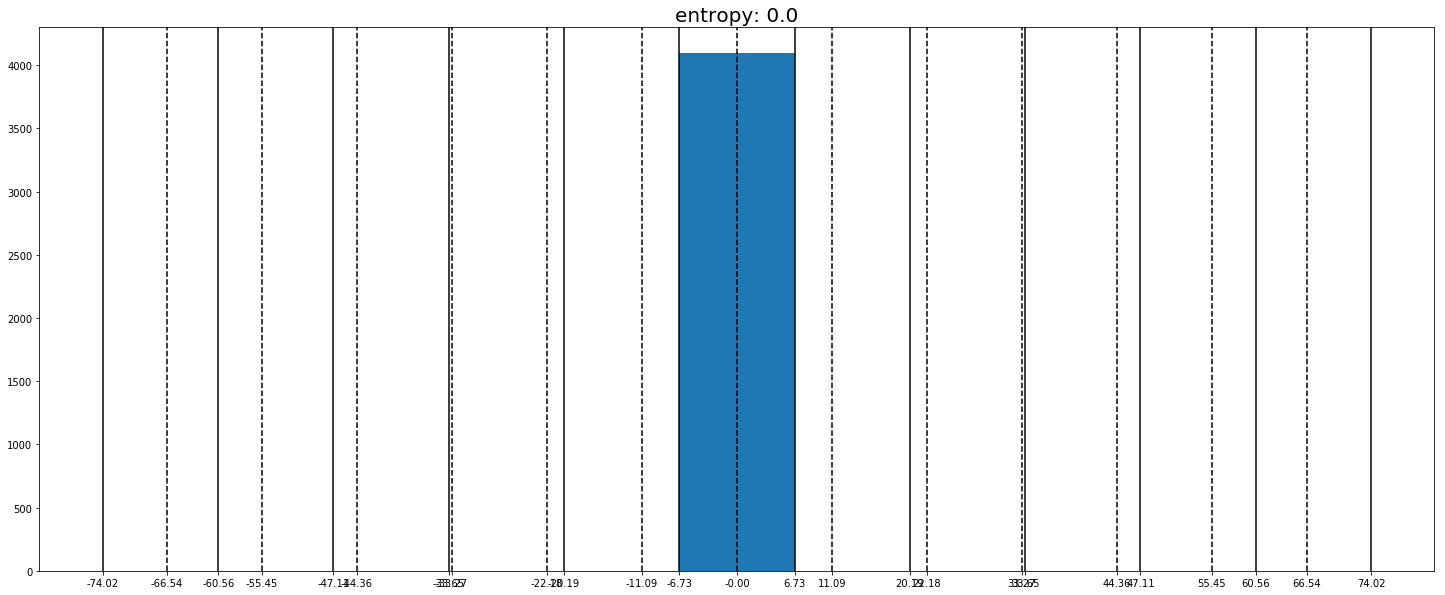

In [28]:
coeff_idx=2
plot_quantization(pca_img_coeffs, coeff_idx, pca_edges[1:-1], pca_centers)

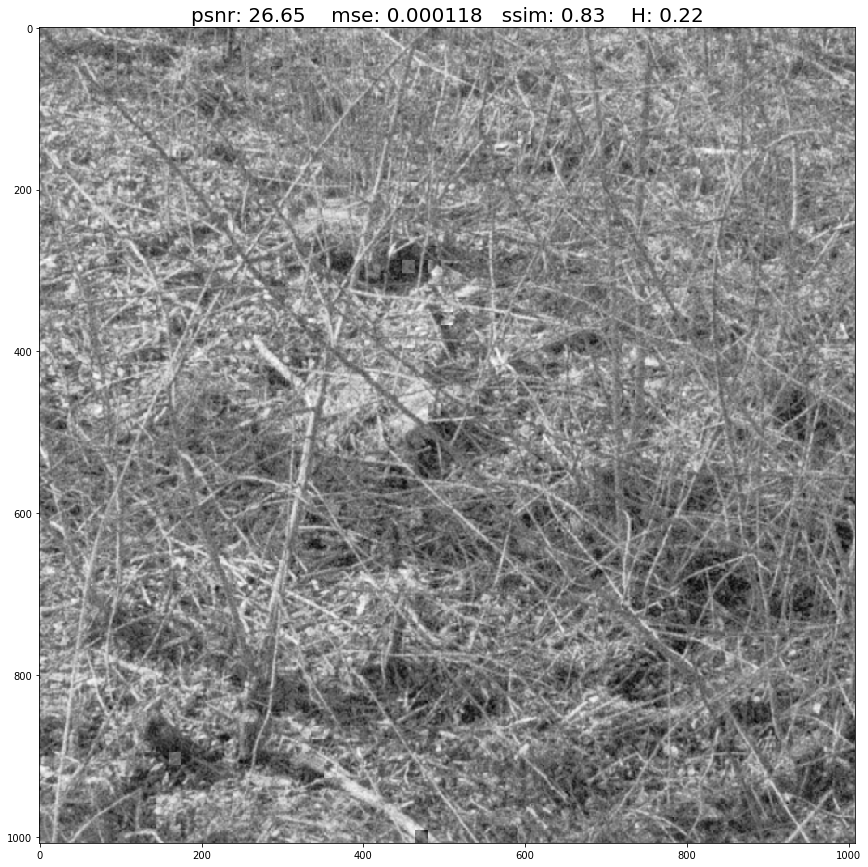

In [14]:
plot_recon(pca_reconstructions, pca_psnr, pca_mse, pca_struc_sim, pca_H)

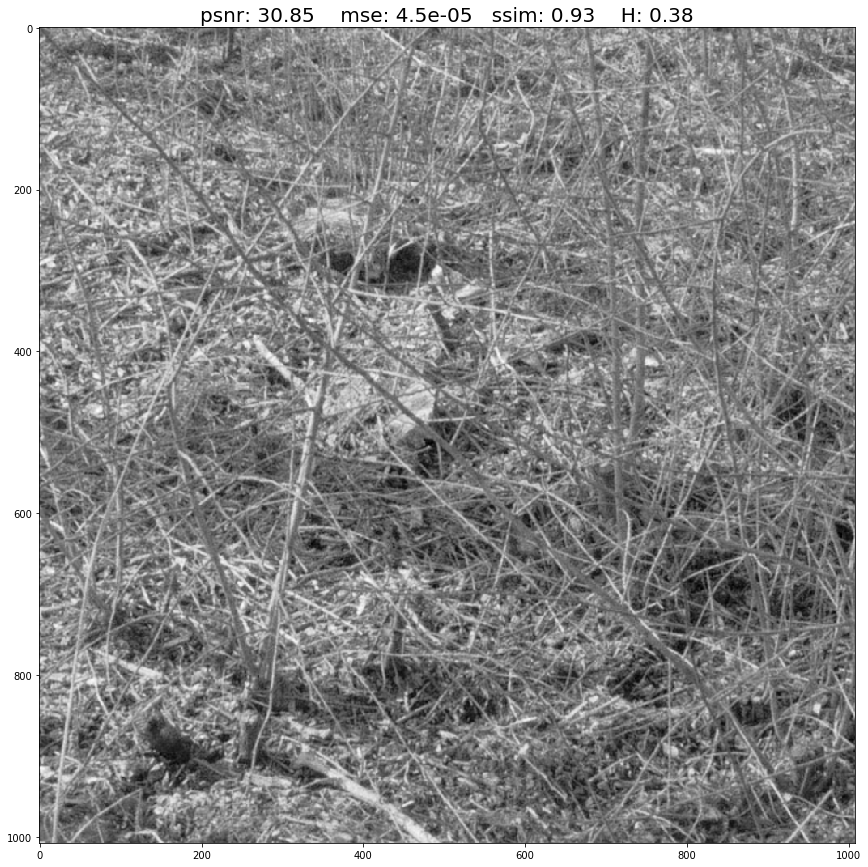

In [105]:
# recon, psnr_db, mse, struc_sim, H
plot_recon(pca_reconstructions, pca_psnr, pca_mse, pca_struc_sim, pca_H)

In [34]:
params = {
    "disc_type": "lloyd_max",
    "set_fixed_range": True,
    "range_min": -40,
    "range_max": 40,
    "model": "ica",
    "white": False,
    "whiten_method": "FT",
    "im_edge_size": 1024,
    "patch_edge_size": 16,
    "n_pixels": 256,
    "num_images": 25,
    "crop_border": True,
    "bin_width": 5
}
img_idx=1

In [35]:
ica_reconstructions, ica_img_coeffs, ica_discretized_coeffs, ica_edges, ica_centers, ica_mse, ica_psnr, ica_struc_sim, ica_H = discretize_and_recon(ica_coeffs, ica_weights, lpf, params, img_idx)

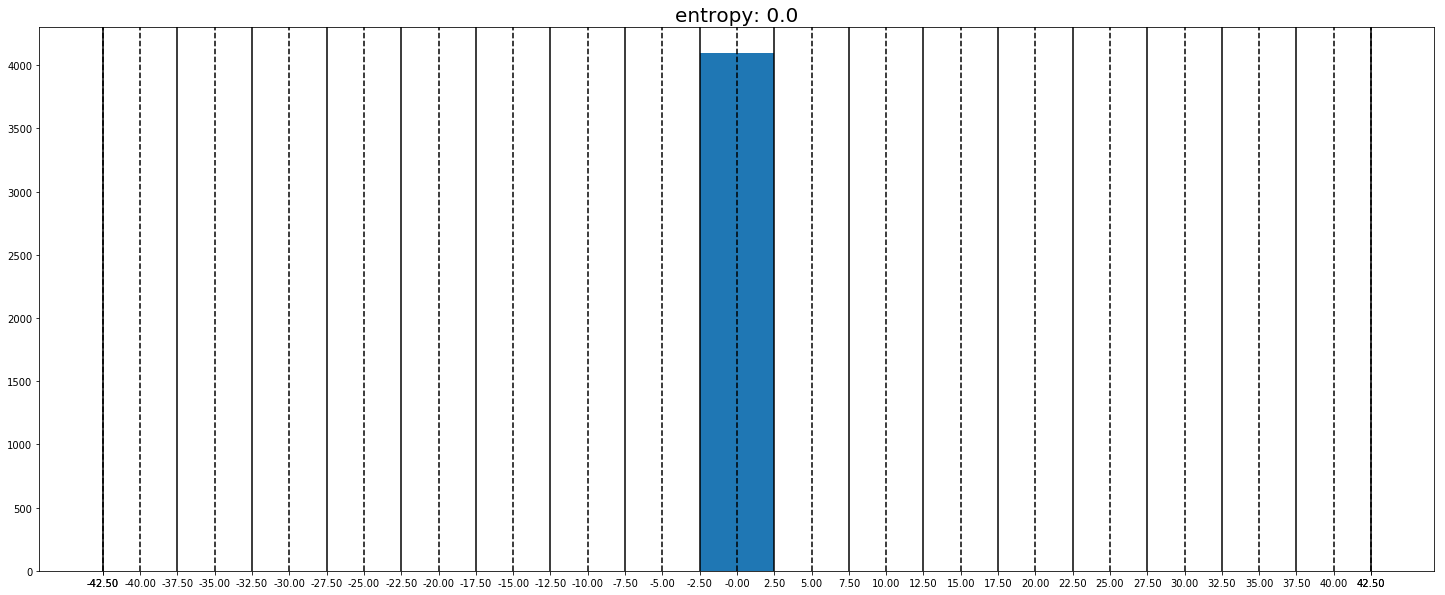

In [25]:
coeff_idx=13
plot_quantization(ica_img_coeffs, coeff_idx, ica_edges, ica_centers)

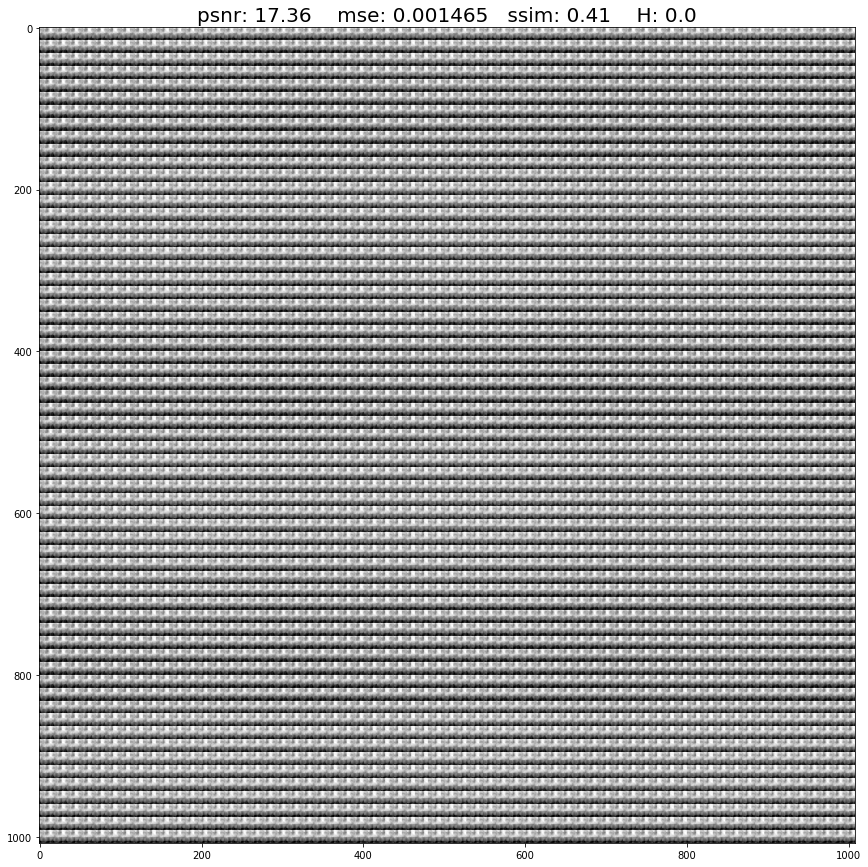

In [28]:
plot_recon(ica_reconstructions, ica_psnr, ica_mse, ica_struc_sim, ica_H)